In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import heartpy as hp
import pandas as pd
import numpy as np 
import pywt as pw
import pickle
import tsfel
import json

2023-11-10 15:19:19.276451: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 15:19:19.444823: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 15:19:19.444848: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 15:19:19.445739: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 15:19:19.523890: I tensorflow/core/platform/cpu_feature_g

# Functions

In [8]:
# TODO Banpass Buttwe
num_of_participants = 23
num_of_clips = 18

#In Hz:
cutoff = [0.5, 5.0]
sample_rate = 256.0
order = 1
filtertype ='bandpass'
def data_filter (data):
    # Separate data by channel
    for participant in data.keys():
        print("Starting " + participant)
        for clip_num in range(0, num_of_clips):
            # Filter both channels from baseline
            CH1 = [row[0] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            
            CH2 = [row[1] for row in data[participant]['ECG']['baseline'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)

            s_clip = "clip " + str(clip_num+1) 

            data[participant]['ECG'][s_clip] = {}
            data[participant]['ECG'][s_clip]['CH1'] = {}
            data[participant]['ECG'][s_clip]['CH1']['baseline'] = CH1_filtered.tolist()
            data[participant]['ECG'][s_clip]['CH2'] = {}
            data[participant]['ECG'][s_clip]['CH2']['baseline'] = CH2_filtered.tolist()

            
            # Filter both channels from stimuli
            CH1 = [row[0] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH1_filtered = hp.filter_signal(CH1, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            
            CH2 = [row[1] for row in data[participant]['ECG']['stimuli'][clip_num]]
            CH2_filtered = hp.filter_signal(CH2, cutoff = cutoff, sample_rate = sample_rate, order = order, filtertype=filtertype)
            
            data[participant]['ECG'][s_clip]['CH1']['stimuli'] = CH1_filtered.tolist()
            data[participant]['ECG'][s_clip]['CH2']['stimuli'] = CH2_filtered.tolist()

            data[participant]['ECG'][s_clip]['ScoreValence'] = data[participant]['ScoreValence'][clip_num]
            data[participant]['ECG'][s_clip]['ScoreArousal'] = data[participant]['ScoreArousal'][clip_num]
            data[participant]['ECG'][s_clip]['ScoreDominance'] = data[participant]['ScoreDominance'][clip_num]
            
            print("Done filtering raw for " + participant + " at clip#" + str(clip_num+1))
        data[participant]['ECG'].pop('stimuli')
        data[participant]['ECG'].pop('baseline')

        data[participant].pop('ScoreValence')
        data[participant].pop('ScoreArousal')
        data[participant].pop('ScoreDominance')
    
    print("All done.... Highpass filter applied, cutoff: " + str(low_frequency) + "Hz and order: " + str(high_frequenc) + "Hz")
    return data
            
            
### Function to display graph
def show_graph(participant, clip, dtype, range_min = 0, range_max = -1):
    plt.plot(filtered_data[participant]['ECG'][dtype][clip][range_min:range_max])
    plt.ylabel("mV")
    plt.xlabel("Sample #")
    graph_title = participant + "  clip#" + str(clip) + " " + dtype + " data range: " + str(range_min) + " => " + str(range_max)
    plt.title(graph_title)

### Function to split channels
def chan_split(filtered_data, participant, clip, dtype):
    ch1 = [row[0] for row in filtered_data[participant]['ECG'][dtype][clip]]
    ch2 = [row[1] for row in filtered_data[participant]['ECG'][dtype][clip]]
    
    return ch1, ch2


### Function to plot Heard Rate Signal Peak Detection
def peak_detection(participant, clip, dtype, ch = 1, range_min = 0, range_max = -1):
    
    p1_c1_ch1, p1_c1_ch2 =(chan_split(participant, clip, dtype))
    wd1 = hp.process(p1_c1_ch1[range_min:range_max], 256)
    wd2 = hp.process(p1_c1_ch1[range_min:range_max], 256)
    if ch == 1:
        hp.plotter(wd1[0], wd1[1])
    else:
        hp.plotter(wd2[0], wd2[1])
            

# Load & Process RAW Data, then create and save processed data to .pkl

Starting participant_1
Done filtering raw for participant_1 at clip#1
Done filtering raw for participant_1 at clip#2
Done filtering raw for participant_1 at clip#3
Done filtering raw for participant_1 at clip#4
Done filtering raw for participant_1 at clip#5
Done filtering raw for participant_1 at clip#6
Done filtering raw for participant_1 at clip#7
Done filtering raw for participant_1 at clip#8
Done filtering raw for participant_1 at clip#9
Done filtering raw for participant_1 at clip#10
Done filtering raw for participant_1 at clip#11
Done filtering raw for participant_1 at clip#12
Done filtering raw for participant_1 at clip#13
Done filtering raw for participant_1 at clip#14
Done filtering raw for participant_1 at clip#15
Done filtering raw for participant_1 at clip#16
Done filtering raw for participant_1 at clip#17
Done filtering raw for participant_1 at clip#18
Starting participant_10
Done filtering raw for participant_10 at clip#1
Done filtering raw for participant_10 at clip#2
Do

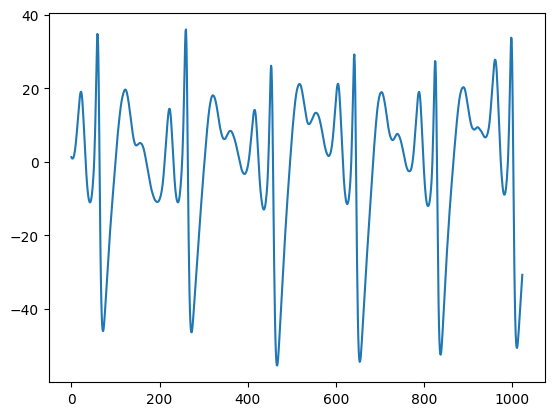

In [9]:
raw_data = {}
load_raw_from = '../data_set_raw_ECG/raw_data_dict.pkl'
dump_to = '../data_set_raw_ECG/processed_data_dict.pkl'

with open(load_raw_from, 'rb') as f:
    raw_data = pickle.load(f)

filtered_data = data_filter(raw_data)

with open(dump_to, 'wb') as f:
    pickle.dump(filtered_data, f)
    print("Dumped proccesed data for " , str(num_of_participants), " participants and ", str(num_of_clips), " ", dump_to)

plt.plot(raw_data['participant_1']['ECG']['clip 1']['CH1']['stimuli'][0:1024])

del raw_data
del filtered_data

# Load Filtered Data

In [13]:
data = {}
load_processed_from = '../data_set_raw_ECG/processed_data_dict.pkl'
with open(load_processed_from, 'rb') as f:
    data = pickle.load(f)

In [15]:
data['participant_1']['ECG']['clip 1'].keys()

dict_keys(['CH1', 'CH2', 'ScoreValence', 'ScoreArousal', 'ScoreDominance'])

# Extract Time Domain

In [38]:
def window_data(processed_data):
    
def extract_time_domain(processed_data):
    features = {}
    cfg = tsfel.get_features_by_domain()
    for participant in processed_data:
        features[participant] = {}
        for clip in processed_data[participant]['ECG']:
            features[participant][clip] = {}
            features[participant][str(clip)]['CH1'] = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])
            features[participant][str(clip)]['CH2'] = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH2']['stimuli'])
            
            features[participant][str(clip)]['ScoreValence'] = data[participant]['ScoreValence']
            features[participant][str(clip)]['ScoreArousal'] = data[participant]['ScoreArousal']
            features[participant][str(clip)]['ScoreDominance'] = data[participant]['ScoreDominance']
            
            print("Done with time features for participant ", participant, " clip ", clip)
    return features

def extract_time_domain_as_pd_df(processed_data):
    combined_data = pd.DataFrame()
    cfg = tsfel.get_features_by_domain()
    for participant in processed_data:
        for clip in processed_data[participant]['ECG']:
            # TODO Create multiple rows with each video, split 
            features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])
            # features_df_ch2 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH2']['stimuli'])
            
            features_df_ch1['ScoreValence'] = data[participant]['ECG'][clip]['ScoreValence']
            features_df_ch1['ScoreArousal'] = data[participant]['ECG'][clip]['ScoreArousal']
            features_df_ch1['ScoreDominance'] = data[participant]['ECG'][clip]['ScoreDominance']

            # features_df_ch2['ScoreValence'] = data[participant]['ECG'][clip]['ScoreValence']
            # features_df_ch2['ScoreArousal'] = data[participant]['ECG'][clip]['ScoreArousal']
            # features_df_ch2['ScoreDominance'] = data[participant]['ECG'][clip]['ScoreDominance']
            
            combined_data = pd.concat([combined_data, features_df_ch1], ignore_index=False) #combined_data.append(features_df_ch1, ignore_index=false)
            #combined_data = combined_data.append(features_df_ch2, ignore_index=false)
            
            print("Done with time features for participant ", participant, " clip ", clip)
    return combined_data


In [ ]:
# Save to dict to .pkl
time_domain_features = extract_time_domain(data)

dump_to = '../features/time_domain_all_dict.pkl'
with open(dump_to, 'wb') as f:
    pickle.dump(time_domain_features, f)
del time_domain_features

In [39]:
# Save pandas df to .pkl

time_domain_df = extract_time_domain_as_pd_df(data)

dump_to = '../features/time_domain_df.pkl'
time_domain_df.to_pickle(dump_to)

del time_domain_features

*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_1  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_10  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_11  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_12  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_13  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_14  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_15  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_16  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_17  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_18  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_19  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_2  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_20  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_21  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_22  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_23  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_3  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_4  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_5  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_6  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_7  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_8  clip  clip 18
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 1
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 2
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 3
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 4
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 5
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 6
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 7
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 8
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 9
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 10
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 11
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 12
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 13
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 14
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 15
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 16
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 17
*** Feature extraction started ***


/tmp/ipykernel_16399/38426624.py:23: UserWarning: Using default sampling frequency set in configuration file.
  features_df_ch1 = tsfel.time_series_features_extractor(cfg, processed_data[participant]['ECG'][clip]['CH1']['stimuli'])



*** Feature extraction finished ***
Done with time features for participant  participant_9  clip  clip 18


NameError: name 'time_domain_features' is not defined

# Train the Model using sklearn

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd

In [48]:
# Load data
features_df = pd.read_pickle('../features/time_domain_df.pkl')

# Split Data into X and Y
X = features_df.drop(['ScoreValence', 'ScoreArousal', 'ScoreDominance'], axis=1)
Y = features_df[['ScoreValence', 'ScoreArousal', 'ScoreDominance']]  # Ensure correct DataFrame is used

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

# Train the SVM
svm_model = SVC(kernel='linear')  # Correctly named SVM model
multi_target_svm = MultiOutputClassifier(svm_model)
multi_target_svm.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = multi_target_svm.predict(X_test)

# Evaluate each target
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    accuracy = accuracy_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"Accuracy for {target}:", accuracy)

Accuracy for Valence: 0.1686746987951807
Accuracy for Arousal: 0.27710843373493976
Accuracy for Dominance: 0.27710843373493976


In [86]:
X = features_df.drop(['ScoreValence', 'ScoreArousal', 'ScoreDominance'], axis=1)
Y = features_df[['ScoreValence', 'ScoreArousal', 'ScoreDominance']]  # Ensure correct DataFrame is used

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

# Train the SVM
svm_model = SVC(kernel='rbf')  # Correctly named SVM model
multi_target_svm = MultiOutputClassifier(svm_model)
multi_target_svm.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = multi_target_svm.predict(X_test)

# Evaluate each target
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    accuracy = accuracy_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"Accuracy for {target}:", accuracy)

Accuracy for Valence: 0.21686746987951808
Accuracy for Arousal: 0.3132530120481928
Accuracy for Dominance: 0.30120481927710846


In [87]:
X = features_df.drop(['ScoreValence', 'ScoreArousal', 'ScoreDominance'], axis=1)
Y = features_df[['ScoreValence', 'ScoreArousal', 'ScoreDominance']]  # Ensure correct DataFrame is used

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

# Train the SVM
svm_model = SVC(kernel='poly')  # Correctly named SVM model
multi_target_svm = MultiOutputClassifier(svm_model)
multi_target_svm.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = multi_target_svm.predict(X_test)

# Evaluate each target
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    accuracy = accuracy_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"Accuracy for {target}:", accuracy)

Accuracy for Valence: 0.24096385542168675
Accuracy for Arousal: 0.3132530120481928
Accuracy for Dominance: 0.3253012048192771


In [25]:
len(features_df)

414

In [11]:
#as per the correlation matrix the features seems to be correlated so applying PCA 
from sklearn.decomposition import PCA

# Load data
features_df = pd.read_pickle('../features/time_domain_df.pkl')

# Split Data into X and Y
X = features_df.drop(['ScoreValence', 'ScoreArousal', 'ScoreDominance'], axis=1)
Y = features_df[['ScoreValence', 'ScoreArousal', 'ScoreDominance']]  # Ensure correct DataFrame is used

# Normalize data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.2, random_state=42)

pca = PCA(0.95) #PCA with 95% variance

X_train = pca.fit_transform(X_train) #PCA on train data
X_test = pca.transform(X_test)#PCA on test data

print(pca.explained_variance_ratio_)

# Train the SVM
svm_model = SVC(kernel='rbf')  # Correctly named SVM model
multi_target_svm = MultiOutputClassifier(svm_model)
multi_target_svm.fit(X_train, Y_train)

# Predict and evaluate
Y_pred = multi_target_svm.predict(X_test)

# Evaluate each target
for i, target in enumerate(['Valence', 'Arousal', 'Dominance']):
    accuracy = accuracy_score(Y_test.iloc[:, i], Y_pred[:, i])
    print(f"Accuracy for {target}:", accuracy)


[0.27889363 0.18898127 0.09167819 0.07703272 0.06535083 0.04955213
 0.03073901 0.02747245 0.02308997 0.01930325 0.0137196  0.01323239
 0.01147627 0.0073173  0.00621428 0.00559264 0.00519981 0.00440785
 0.00413351 0.00392787 0.00351656 0.00315501 0.00294211 0.00276759
 0.00266374 0.00250915 0.00239475 0.00204353 0.00200533]
Accuracy for Valence: 0.21686746987951808
Accuracy for Arousal: 0.3132530120481928
Accuracy for Dominance: 0.30120481927710846


In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import metrics

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly']} 
  
grid = GridSearchCV(multi_target_svm, param_grid, refit = True, verbose = 3) #Grid model definition
  
grid.fit(X_train, Y_train) #fit the grid mode

Fitting 5 folds for each of 50 candidates, totalling 250 fits


ValueError: Invalid parameter 'C' for estimator MultiOutputClassifier(estimator=SVC()). Valid parameters are: ['estimator', 'n_jobs'].